### Setting

In [1]:
%%capture
# 필요한 라이브러리 다운로드
!pip install gdown
!pip install transformers
!pip install sentencepiece # MarianTokenizer 불러올 때 필요
!pip install sacremoses # MarianMTModel 에서 불러올 때 warning 뜨는 것 방지
!pip install einops # 지리는 einops 쓰기 (Einstein operations)

In [19]:
# Import Library
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

import torch
from torch import nn, optim
from transformers import MarianTokenizer # MT: Machine Translation
import pandas as pd
from tqdm import tqdm
import math, random
from einops import rearrange
from torch.cuda.amp import GradScaler, autocast

# Define DEVICE
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# Set random seed
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(random_seed)

cuda


#### Hyperparameter

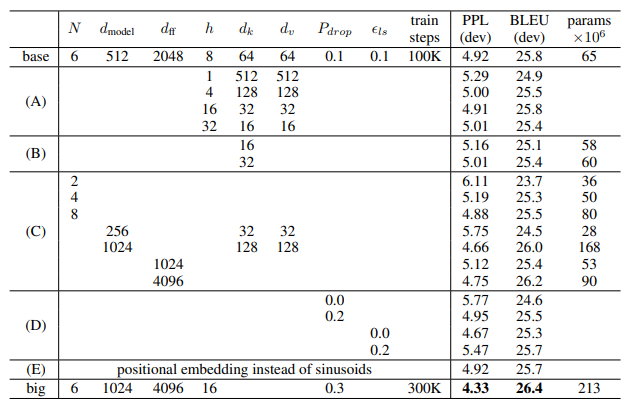

> -  Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.

In [3]:
# Tokenizer
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')
eos_idx = tokenizer.eos_token_id
pad_idx = tokenizer.pad_token_id
vocab_size = tokenizer.vocab_size

# Hyperparameter
BATCH_SIZE = 64 # < 25,000
LAMBDA = 0 # l2-Regularization
EPOCH = 30
max_len = 100 # < 512
patience = 3

# Model Parameter
N = 3 # < 6
d_model = 256 # < 512
d_ff = 512 # < 2048
h = 8 # < 8
p_drop = 0.1 # < 0.1

# Trainig
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
## Noam Scheduler
warmup_steps = 1000 # < 4000
LR_scale = 0.5
scaler = GradScaler()

# Path
save_model_path = 'Transformer_small.pt'
save_history_path = 'Transformer_small_history.pt'

#### Custom Dataset

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data) -> None:
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data.loc[index, '원문'], self.data.loc[index, '번역문']
    
data = pd.read_excel('대화체.xlsx')    
custom_DS = CustomDataset(data=data)

train_DS, val_DS, test_DS= torch.utils.data.random_split(custom_DS, [95000, 3000, 2000])

BATCH_SIZE = 64
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

95000
3000
2000


### 모델 구현

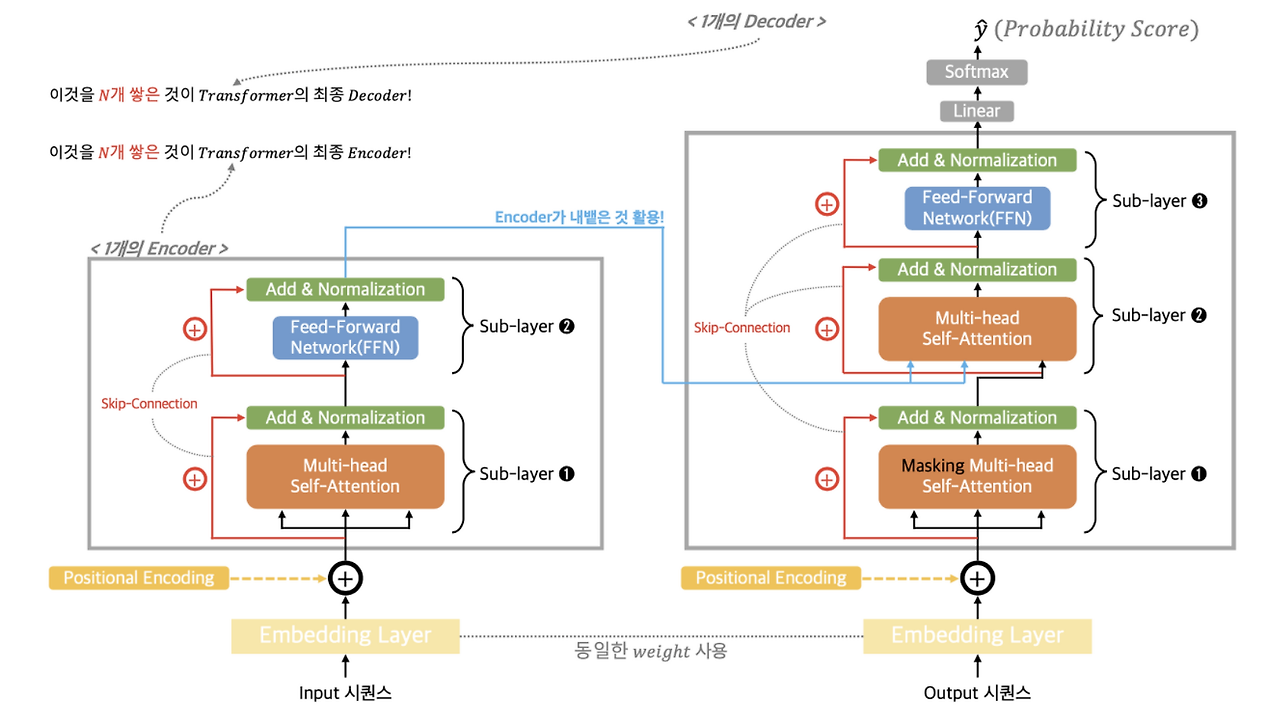

#### `Multi-Head Attention`

In [5]:
class MHA(nn.Module):
    def __init__(self, d_model, h):
        super().__init__()
        
        self.h = h
        
        # 아래 einops 라이브러리를 활용하여 q,k,v 를 8개로 나누어 연산하는 구현을 간소화
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)
        
        self.atten_scale = torch.sqrt(torch.tensor(d_model / h))
        
    def forward(self, Q, K, V, mask=None):
        
        # Query & Key & Value
        Q = self.fc_q(Q)
        K = self.fc_k(K)
        V = self.fc_v(V)
        
        # B: Batch Size, W: 단어의 개수, H: Multi-head 개수, E: embedding 차원
        # [B, W, E]
        # -> [B, H, W, E/H]
        Q = rearrange(Q, 'B W (H E) -> B H W E', H = self.h)
        K = rearrange(K, 'B W (H E) -> B H W E', H = self.h)
        V = rearrange(V, 'B W (H E) -> B H W E', H = self.h)
        
        # QK^T / sqrt(d_k)
        attention_score = Q @ K.transpose(-2, -1) / self.atten_scale # B H W W
        
        # Masking
        if mask is not None:
            attention_score[mask] = -1e10
        
        # Softmax
        attention_weights = torch.softmax(attention_score, dim=-1)
        
        # (QK^T)V
        attention = attention_weights @ V # B H W E/H
        
        x = rearrange(attention, 'B H W E -> B W (H E)')
        x = self.fc_o(x)
        
        return x, attention_weights

#### FeedForward

In [6]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(d_model, d_ff),
                                    nn.ReLU(),
                                    nn.Dropout(drop_p), 
                                    nn.Linear(d_ff, d_model))

    def forward(self, x):
        x = self.linear(x)
        return x

#### `Encoder`

In [7]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, h, d_ff, drop_p):
        super().__init__()
        
        self.self_atten = MHA(d_model, h)
        self.self_atten_LN = nn.LayerNorm(d_model)
        
        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x, enc_mask):
        
        residual, atten_enc = self.self_atten(x,x,x,enc_mask)
        residual = self.dropout(residual)
        x = self.self_atten_LN(x+residual)
        
        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x+residual)
        
        return x, atten_enc
    
class Encoder(nn.Module):
    def __init__(self, input_embedding, max_len, N, d_model, d_ff, h, drop_p) -> None:
        super().__init__()
        
        self.input_scale = torch.sqrt(torch.tensor(d_model))
        self.input_embedding = input_embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)
        
        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([EncoderLayer(d_model, h, d_ff, drop_p) for _ in range(N)])
        
    def forward(self, src, mask, atten_map_save=False):
        
        pos = torch.arange(src.shape[1]).expand_as(src).to(DEVICE)
        
        x = self.input_scale * self.input_embedding(src) + self.pos_embedding(pos)
        x = self.dropout(x)
        
        atten_encs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_enc = layer(x, mask)
            if atten_map_save:
                '''
                    atten_enc[0]: 첫 번째 배치에 해당하는 attention map을 가져오는 것
                    unsqueeze(0): 텐서의 첫 번째 차원(0번 차원)에 크기가 1인 차원을 추가하는 연산
                    -> [N(layers의 길이), multi-head attention의 head 수, 입력 시퀀스의 길이, 입력 시퀀스의 길이]
                        의 attention map 을 확인해 볼 수 있다. (batch 내 0번 입력에 대해서)
                '''
                atten_encs = torch.cat([atten_encs, atten_enc[0].unsqueeze(0)], dim=0)
                
        return x, atten_encs        

#### `Decoder`

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, h, drop_p):
        super().__init__()
        
        self.self_atten = MHA(d_model, h)
        self.self_atten_LN = nn.LayerNorm(d_model)
        
        self.enc_dec_atten = MHA(d_model, h)
        self.enc_dec_atten_LN = nn.LayerNorm(d_model)
        
        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x, enc_out, dec_mask, enc_dec_mask):
        
        residual, atten_dec = self.self_atten(x, x, x, dec_mask)
        residual = self.dropout(residual)
        x = self.self_atten_LN(x + residual)
        
        # Query: x
        # Key, Value: encoder 의 output
        residual, atten_enc_dec = self.enc_dec_atten(x, enc_out, enc_out, enc_dec_mask)
        residual = self.dropout(residual)
        x = self.enc_dec_atten_LN(x + residual)
        
        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x+residual)
        
        return x, atten_dec, atten_enc_dec
    
class Decoder(nn.Module):
    def __init__(self, input_embedding, max_len, N, d_model, d_ff, h, drop_p, vocab_size):
        super().__init__()
        
        self.input_scale = torch.sqrt(torch.tensor(d_model))
        self.input_embedding = input_embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)
        
        self.dropout = nn.Dropout(drop_p)
        
        self.layers = nn.ModuleList([DecoderLayer(d_model, d_ff, h, drop_p) for _ in range(N)])
        
        self.fc_out = nn.Linear(d_model, vocab_size)
        
    def forward(self, trg, enc_out, dec_mask, enc_dec_mask, atten_map_save=True):
        
        pos = torch.arange(trg.shape[1]).expand_as(trg).to(DEVICE)
        
        x = self.input_scale * self.input_embedding(trg) + self.pos_embedding(pos)
        x = self.dropout(x)
        
        atten_decs = torch.tensor([]).to(DEVICE)
        atten_enc_decs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_dec, atten_enc_dec = layer(x, enc_out, dec_mask, enc_dec_mask)
            if atten_map_save:
                atten_decs = torch.cat([atten_decs, atten_dec[0].unsqueeze(0)], dim=0)
                atten_enc_decs = torch.cat([atten_enc_decs, atten_enc_dec[0].unsqueeze(0)], dim=0)
                
        x = self.fc_out(x)
        return x, atten_decs, atten_enc_decs

#### `Transformer`

`Mask`
- Encoder Mask & Encoder + Decoder Mask
    - $<pad>$ token 을 masking 하여 불필요한 학습이 이루어지지 않도록 한다.
    - 이때 Query 가 $<pad>$ 인 경우는 지워지지 않고 Encoder + Decoder 의 Attention layer 로 넘어가 지워지게 된다.
- Decoder Mask
- $<pad>$ token 뿐만 아니라 현재 시점 이후 문장을 masking 하여 컨닝을 방지한다.

In [9]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, h, drop_p):
        super().__init__()
        
        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.encoder = Encoder(self.input_embedding, max_len, n_layers, d_model, d_ff, h, drop_p)
        self.decoder = Decoder(self.input_embedding, max_len, n_layers, d_model, d_ff, h, drop_p, vocab_size)
        
        self.h = h
        
    def make_enc_mask(self, src): # src.shape = B W
        enc_mask = (src==pad_idx).unsqueeze(1).unsqueeze(2) # B 1 1 W
        enc_mask = enc_mask.expand(src.shape[0], self.h, src.shape[1], src.shape[1]) # B H W W
        
        return enc_mask
        
    def make_dec_mask(self, trg): 

        trg_pad_mask = (trg == pad_idx).unsqueeze(1).unsqueeze(2) 
        trg_pad_mask = trg_pad_mask.expand(trg.shape[0], self.h, trg.shape[1], trg.shape[1]) 

        trg_future_mask = torch.tril(torch.ones(trg.shape[0], self.h, trg.shape[1], trg.shape[1]))==0 
        trg_future_mask = trg_future_mask.to(DEVICE)

        dec_mask = trg_pad_mask | trg_future_mask 

        return dec_mask

    def make_enc_dec_mask(self, src, trg):

        enc_dec_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2)
        enc_dec_mask = enc_dec_mask.expand(trg.shape[0], self.h, trg.shape[1], src.shape[1])
        
        return enc_dec_mask
    
    def forward(self, src, trg):
        
        enc_mask = self.make_enc_mask(src)
        dec_mask = self.make_dec_mask(trg)
        enc_dec_mask = self.make_enc_dec_mask(src, trg)
        
        enc_out, atten_enc = self.encoder(src, enc_mask)
        out, atten_dec, atten_enc_dec = self.decoder(trg, enc_out, dec_mask, enc_dec_mask)
        
        return out, atten_enc, atten_dec, atten_enc_dec   


### 모델 생성 및 테스트

In [10]:
model = Transformer(vocab_size, max_len, N, d_model, d_ff, h, p_drop).to(DEVICE)

src = torch.tensor([[4,6,5,1,1,1],[7,7,1,1,1,1]]).to(DEVICE)
trg = torch.tensor([[2,5,4,4,3,1,1],[2,9,6,7,3,1,1]]).to(DEVICE)

model.eval()
with torch.no_grad():
    x = model(src, trg)[0]
print(trg.shape)
print(x.shape)

torch.Size([2, 7])
torch.Size([2, 7, 65001])


### Train method

In [14]:
def loss_epoch(model, DL, criterion, optimizer=None, scheduler=None, scaler=None):
    N = len(DL.dataset)
    
    rloss = 0
    for src_texts, trg_texts in tqdm(DL, unit='batch'):
        src = tokenizer(src_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt', add_special_tokens = False).input_ids.to(DEVICE)
        trg_texts = ['</s> ' + s for s in trg_texts]
        trg = tokenizer(trg_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids.to(DEVICE)
        
        # Inference
        preds = model(src, trg[:, :-1])[0] # 모델을 통과시킬 떄, target 의 마지막 token 은 제거.
        # loss
        '''
            토크나이저의 어휘 크기에 대해서, 어떤 토큰 인덱스가 정답인지를 찾아가는 과정.
            첫 번째 토큰에 대한 정답: [0,0,0, ... , 1, ... , 0]
            첫 번째 토큰에 대한 예측: [0.01, 0.03, 0.0005, ..., 0.8, ..., 0]
            에 대한 Loss 를 계산하는 것!
        '''
        loss = criterion(preds.permute(0,2,1), trg[:,1:]) # loss 계산 시엔 <sos> 는 제외!
        # update
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        # loss accumulation
        loss_b = loss.item() * src.shape[0]
        rloss += loss_b
        
    loss_e = rloss/N
    return loss_e

def Train(model, train_DL, val_DL, EPOCH, criterion, optimizer, scheduler, scaler):
    loss_history = {"train": [], "val": []}
    best_loss = 9999
    early_stopping_cnt = 0
    
    for ep in range(EPOCH):
        model.train()
        train_loss = loss_epoch(model, train_DL, criterion, optimizer, scheduler, scaler)
        loss_history["train"] += [train_loss] 
        
        model.eval() # test mode로 전환
        with torch.no_grad():
            val_loss = loss_epoch(model, val_DL, criterion)
            loss_history["val"] += [val_loss]
            
            print(f"Epoch {ep+1}: train loss: {train_loss:.5f}   val loss: {val_loss:.5f}   current_LR: {optimizer.param_groups[0]['lr']:.8f}")
            print("-" * 20)
            
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({"model": model,
                            "ep": ep,
                            "optimizer": optimizer,
                            "scheduler": scheduler,}, save_model_path)
            else:
                early_stopping_cnt += 1
                if early_stopping_cnt >= patience:
                    break
        # print loss
        

    torch.save({"loss_history": loss_history,
                "EPOCH": EPOCH,
                "BATCH_SIZE": BATCH_SIZE}, save_history_path)

#### Scheduler

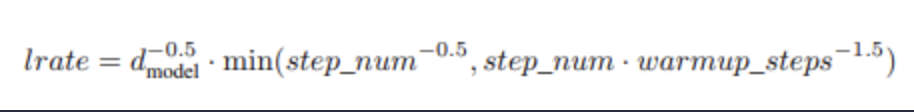

In [12]:
class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps, LR_scale = 1):
        self.optimizer = optimizer
        self.current_step = 0
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.LR_scale = LR_scale

    def step(self):
        self.current_step += 1
        lrate = self.LR_scale * (self.d_model ** -0.5) * min(self.current_step ** -0.5, self.current_step * self.warmup_steps ** -1.5)
        self.optimizer.param_groups[0]['lr'] = lrate

### Train

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0,
                               betas=(0.9, 0.98), eps=1e-9, # 논문에서 제시한 beta와 eps 사용
                               weight_decay=LAMBDA)# l2-Regularization 
scheduler = NoamScheduler(optimizer, d_model=d_model, warmup_steps=warmup_steps, LR_scale=LR_scale) # 맨 처음 step 의 LR=0으로 출발 (warm-up)

Train(model, train_DL, val_DL, EPOCH, criterion, optimizer, scheduler, scaler)

100%|██████████| 47/47 [00:01<00:00, 26.50batch/s]


Epoch 1: train loss: 3.80525   val loss: 2.39149   current_LR: 0.00081094
--------------------


100%|██████████| 47/47 [00:01<00:00, 27.61batch/s]


Epoch 2: train loss: 2.26288   val loss: 2.02590   current_LR: 0.00057342
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.09batch/s]


Epoch 3: train loss: 2.00490   val loss: 1.86814   current_LR: 0.00046819
--------------------


100%|██████████| 47/47 [00:01<00:00, 27.04batch/s]


Epoch 4: train loss: 1.86759   val loss: 1.79197   current_LR: 0.00040547
--------------------


100%|██████████| 47/47 [00:01<00:00, 27.05batch/s]


Epoch 5: train loss: 1.77640   val loss: 1.73547   current_LR: 0.00036266
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.89batch/s]


Epoch 6: train loss: 1.70833   val loss: 1.68816   current_LR: 0.00033106
--------------------


100%|██████████| 47/47 [00:01<00:00, 27.23batch/s]


Epoch 7: train loss: 1.65607   val loss: 1.66338   current_LR: 0.00030651
--------------------


100%|██████████| 47/47 [00:01<00:00, 25.88batch/s]


Epoch 8: train loss: 1.61248   val loss: 1.63928   current_LR: 0.00028671
--------------------


100%|██████████| 47/47 [00:01<00:00, 25.88batch/s]


Epoch 9: train loss: 1.57642   val loss: 1.61755   current_LR: 0.00027031
--------------------


100%|██████████| 47/47 [00:01<00:00, 27.25batch/s]


Epoch 10: train loss: 1.54538   val loss: 1.60549   current_LR: 0.00025644
--------------------


100%|██████████| 47/47 [00:01<00:00, 25.76batch/s]


Epoch 11: train loss: 1.51828   val loss: 1.59433   current_LR: 0.00024451
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.14batch/s]


Epoch 12: train loss: 1.49388   val loss: 1.57954   current_LR: 0.00023410
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.88batch/s]


Epoch 13: train loss: 1.47239   val loss: 1.57311   current_LR: 0.00022491
--------------------


100%|██████████| 47/47 [00:01<00:00, 28.13batch/s]


Epoch 14: train loss: 1.45321   val loss: 1.56375   current_LR: 0.00021673
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.18batch/s]


Epoch 15: train loss: 1.43530   val loss: 1.55815   current_LR: 0.00020938
--------------------


100%|██████████| 47/47 [00:01<00:00, 25.82batch/s]


Epoch 16: train loss: 1.41900   val loss: 1.55662   current_LR: 0.00020273
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.95batch/s]


Epoch 17: train loss: 1.40300   val loss: 1.54909   current_LR: 0.00019668
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.07batch/s]


Epoch 18: train loss: 1.39008   val loss: 1.54324   current_LR: 0.00019114
--------------------


100%|██████████| 47/47 [00:01<00:00, 27.09batch/s]


Epoch 19: train loss: 1.37743   val loss: 1.53985   current_LR: 0.00018604
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.23batch/s]


Epoch 20: train loss: 1.36460   val loss: 1.53485   current_LR: 0.00018133
--------------------


100%|██████████| 47/47 [00:01<00:00, 25.81batch/s]


Epoch 21: train loss: 1.35316   val loss: 1.53435   current_LR: 0.00017696
--------------------


100%|██████████| 47/47 [00:01<00:00, 27.16batch/s]


Epoch 22: train loss: 1.34247   val loss: 1.52574   current_LR: 0.00017289
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.28batch/s]


Epoch 23: train loss: 1.33208   val loss: 1.52219   current_LR: 0.00016909
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.21batch/s]


Epoch 24: train loss: 1.32293   val loss: 1.52181   current_LR: 0.00016553
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.33batch/s]


Epoch 25: train loss: 1.31364   val loss: 1.51815   current_LR: 0.00016219
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.00batch/s]


Epoch 26: train loss: 1.30529   val loss: 1.51859   current_LR: 0.00015904
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.07batch/s]


Epoch 27: train loss: 1.29631   val loss: 1.51542   current_LR: 0.00015606
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.23batch/s]


Epoch 28: train loss: 1.28900   val loss: 1.51369   current_LR: 0.00015325
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.17batch/s]


Epoch 29: train loss: 1.28149   val loss: 1.51059   current_LR: 0.00015059
--------------------


100%|██████████| 47/47 [00:01<00:00, 27.01batch/s]


Epoch 30: train loss: 1.27498   val loss: 1.51003   current_LR: 0.00014806
--------------------


#### Load Model

In [17]:
loaded = torch.load(save_model_path, map_location=DEVICE)
load_model = loaded["model"]
ep = loaded["ep"]
optimizer = loaded["optimizer"]

loaded = torch.load(save_history_path, map_location=DEVICE)
loss_history = loaded["loss_history"]

print(ep)
print(optimizer)

29
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.98)
    capturable: False
    differentiable: False
    eps: 1e-09
    foreach: None
    fused: None
    lr: 0.00014805605302472947
    maximize: False
    weight_decay: 0
)


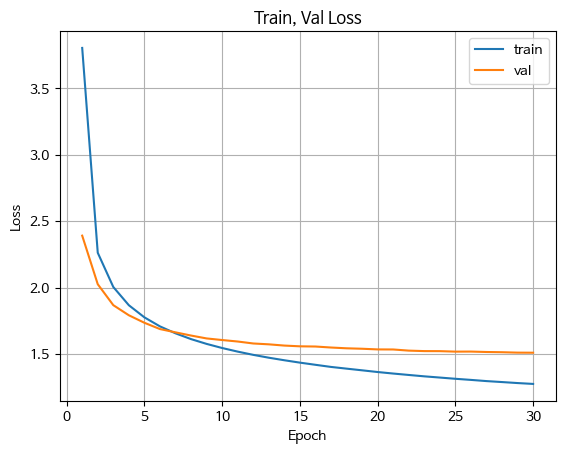

In [20]:
plt.figure()
plt.plot(range(1,EPOCH+1),loss_history["train"], label="train")
plt.plot(range(1,EPOCH+1),loss_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.grid()
plt.legend()

In [21]:
def Test(model, test_DL, criterion):
    model.eval() # test mode로 전환
    with torch.no_grad():
        test_loss = loss_epoch(model, test_DL, criterion)
    print(f"Test loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}")

def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

In [22]:
Test(load_model, test_DL, criterion) 
                                     
count_params(load_model)

100%|██████████| 32/32 [00:01<00:00, 24.46batch/s]

Test loss: 1.483 | Test PPL: 4.408


37350377

In [24]:
def translation(model, src_text, atten_map_save = False):
    model.eval()
    with torch.no_grad():
        src = tokenizer.encode(src_text, return_tensors='pt', add_special_tokens=False).to(DEVICE) # 1x단
        enc_mask = model.make_enc_mask(src)
        enc_out, atten_encs = model.encoder(src, enc_mask, atten_map_save)

        pred = tokenizer.encode('</s>', return_tensors='pt', add_special_tokens=False).to(DEVICE) # 1x1
        for _ in range(max_len-1): # <sos> 가 한 토큰이기 때문에 최대 99 번까지만 loop을 돌아야 함
            dec_mask = model.make_dec_mask(pred)
            enc_dec_mask = model.make_enc_dec_mask(src, pred)
            out, atten_decs, atten_enc_decs = model.decoder(pred, enc_out, dec_mask, enc_dec_mask, atten_map_save)
            # out.shape = (개=1,단,차)

            pred_word = out[:,-1,:].argmax(dim=1).unsqueeze(0) # 마지막 단어에 대해 argmax해서 prediction 하고 shape = (1,1)로
            pred = torch.cat([pred, pred_word], dim=1) # 1x단 (단은 하나씩 늘면서)

            if tokenizer.decode(pred_word.item()) == '</s>':
                break

        translated_text = tokenizer.decode(pred[0])

    return translated_text, atten_encs, atten_decs, atten_enc_decs

def show_attention(atten, Query, Key, n):
    atten = atten.cpu()

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[atten.shape[3]*1.5,atten.shape[2]])
    for i in range(3):
        ax[i].set_yticks(range(atten.shape[2]))
        ax[i].set_yticklabels(Query, rotation=45)
        ax[i].set_xticks(range(atten.shape[3]))
        ax[i].set_xticklabels(Key, rotation=60)
        ax[i].imshow(atten[n][i], cmap='bone') # n 번째 layer, 앞 세 개의 헤드만 plot
        # ax[i].xaxis.tick_top()  # x축 레이블을 위쪽으로 이동

In [37]:
# 번역해보기
i = 10
idx = test_DS.indices[i]
src_text, trg_text = custom_DS.__getitem__(idx)
print(f"입력: {src_text}")
print(f"정답: {trg_text}")

translated_text, atten_encs, atten_decs, atten_enc_decs = translation(load_model, src_text, atten_map_save = True)
print(f"AI의 번역: {translated_text}")

입력: 계산서가 잘못 찍힌 거 같은데 확인해 주실 수 있나요?
정답: I think the check is wrong here, can you double-check?
AI의 번역: </s> I think the cashier was wrong, can you check it?</s>


/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


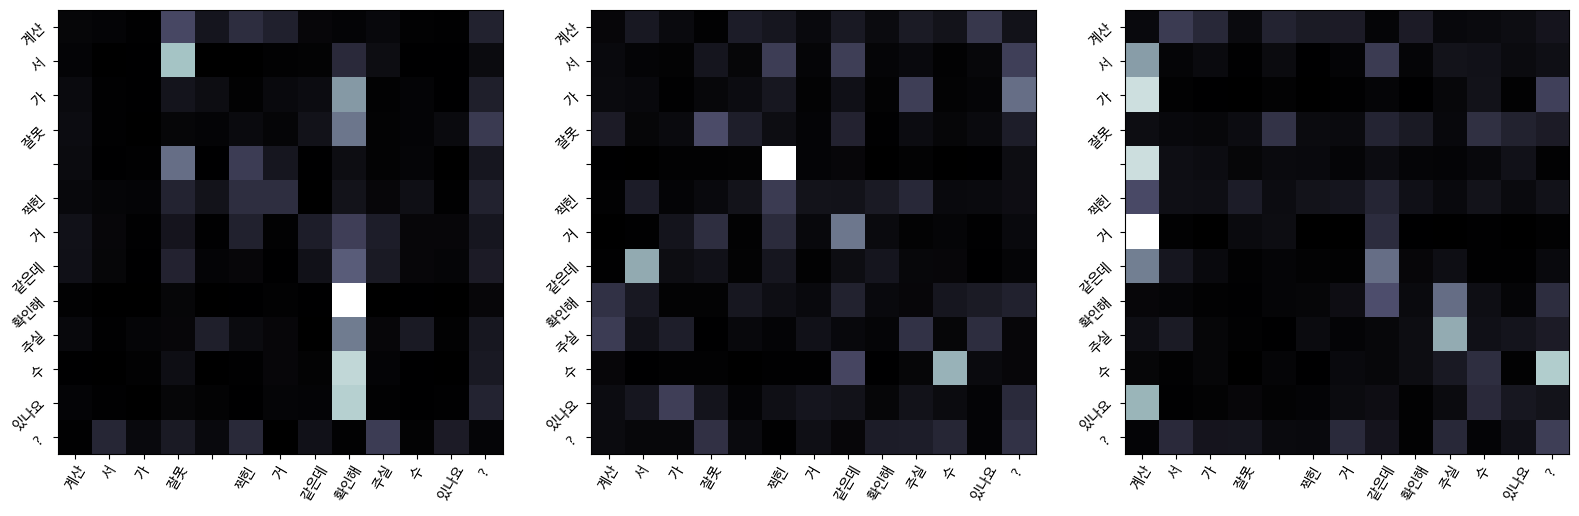

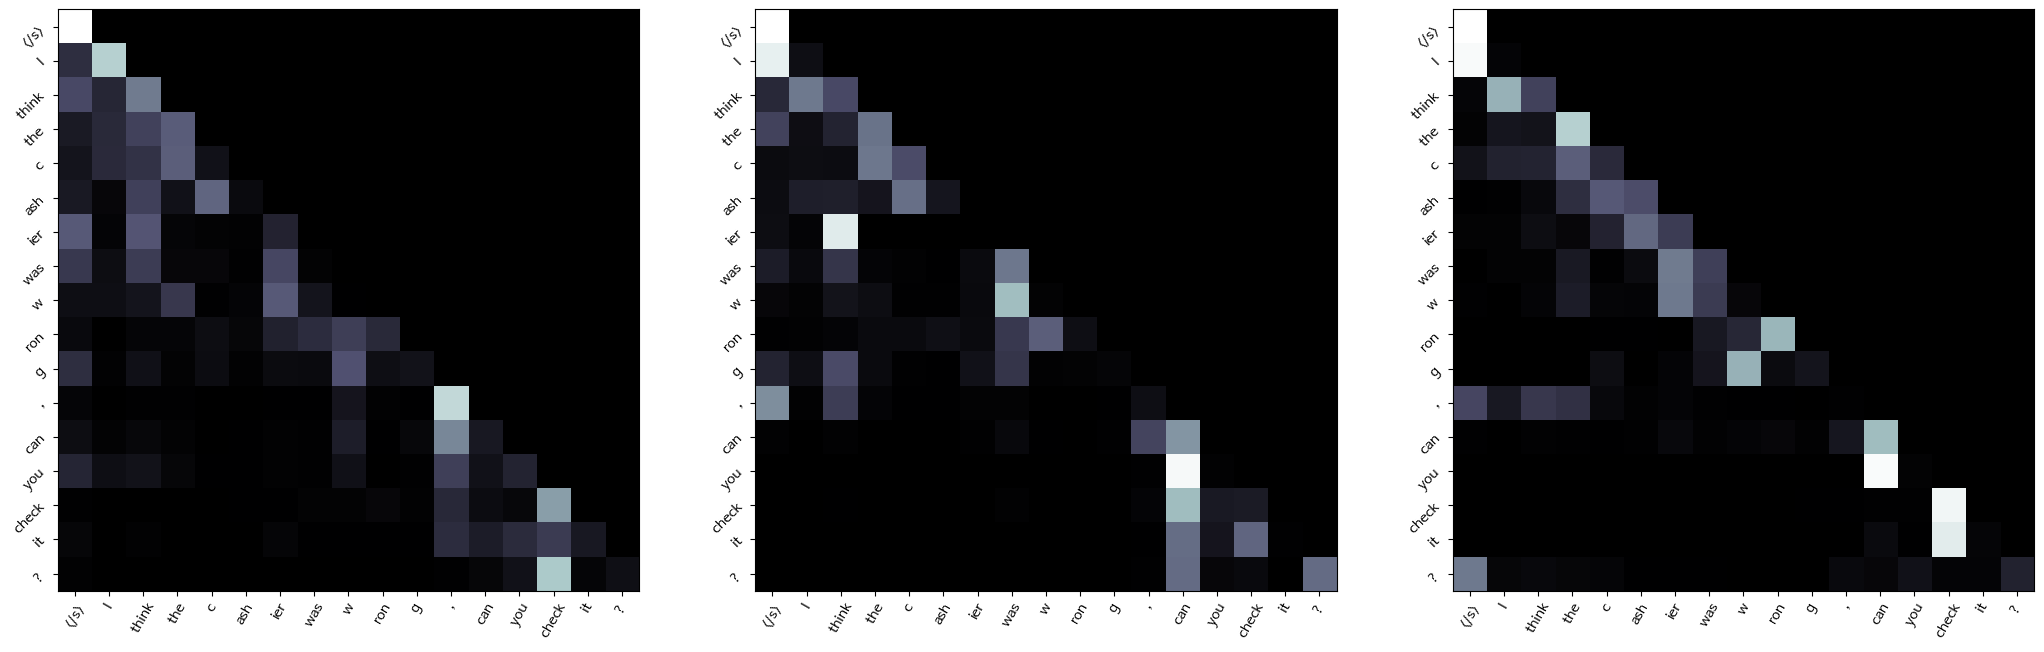

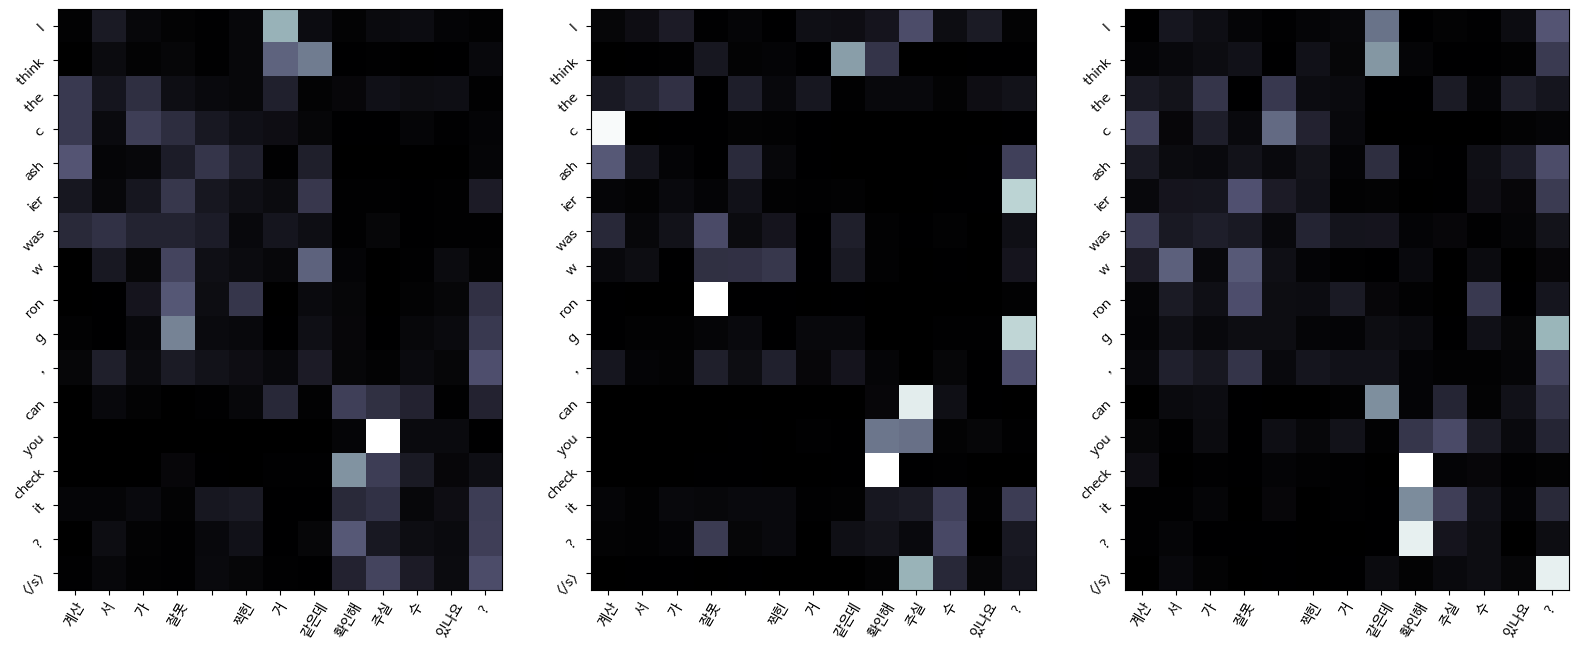

In [42]:
enc_input = tokenizer.tokenize(src_text)
dec_tokens = tokenizer.tokenize(translated_text)
dec_input = dec_tokens[:-1] # 디코더 입력으로 들어가는 문장(sos 는 있고 eos는 없고)
dec_output = dec_tokens[1:] # 디코더 출력으로 나간 문장

# 이 map을 해석할 때는 "이 단어가 나오게끔 뭘 주목했느냐" 로 해석해줘야 함 (ytick에 들어가는 단어가 아닌 예측한 단어를 썼기 때문)
show_attention(atten_encs, enc_input, enc_input, n = 2) 
show_attention(atten_decs, dec_input, dec_input, n = 2)
show_attention(atten_enc_decs, dec_output, enc_input, n = 2) 

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


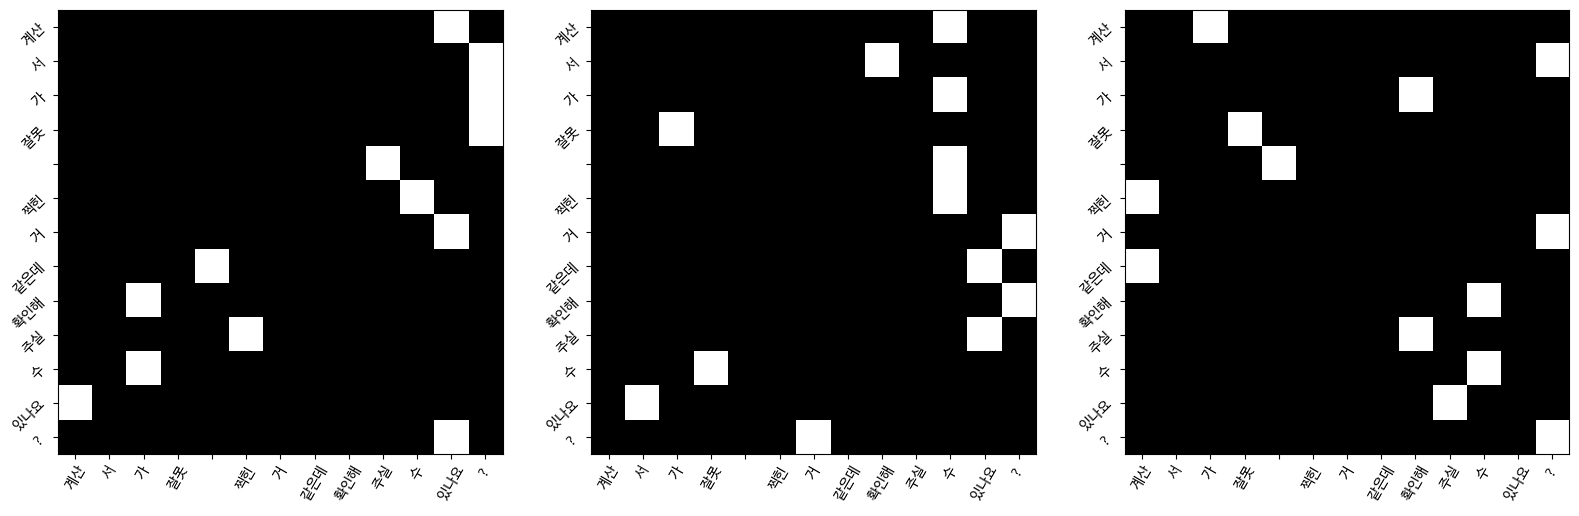

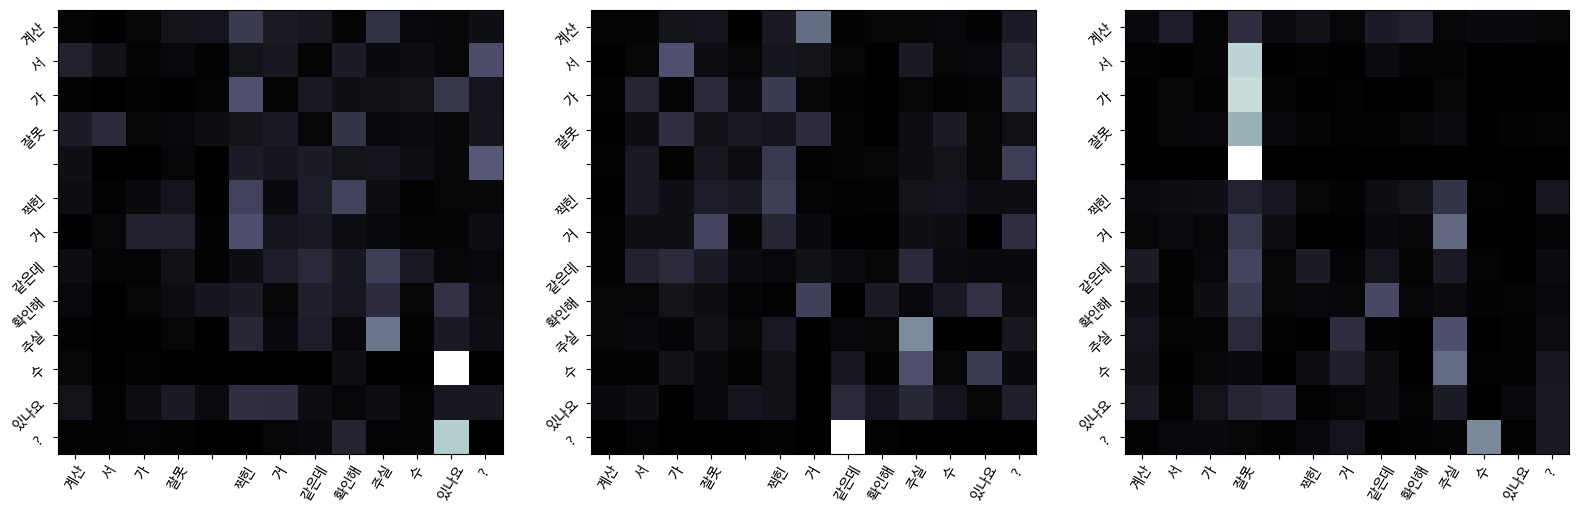

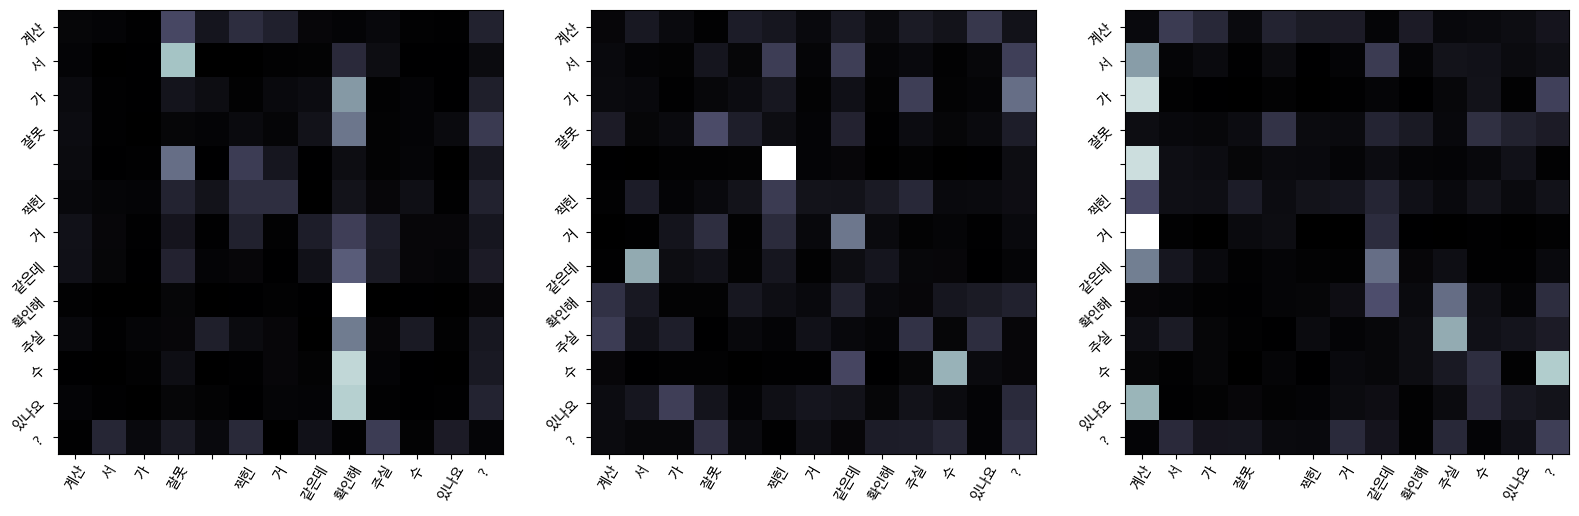

In [43]:
show_attention(atten_encs, enc_input, enc_input, n = 0)
show_attention(atten_encs, enc_input, enc_input, n = 1)
show_attention(atten_encs, enc_input, enc_input, n = 2)

---